In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
moves_df = pd.read_csv("../Data/moves_df.csv")

In [3]:
moves_df.head()

,game_index,moves,evaluation,fen,zobrist_key
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797


In [4]:
moves_df_reduc = moves_df[['game_index', 'moves', 'fen']]

### Move statistics

In [5]:
L = ['T', 'C', 'F', 'K', 'Q', 'F', 'C', 'T', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'p', 'p','p', 'p', 'p', 'p', 'p', 'p', 't', 'c', 'f', 'q', 'k', 'f', 'c', 't']
#print(len(L))
CapturedWhite = []
CapturedBlack = []
ListeWhite = ['P', 'T', 'C', 'F', 'K', 'Q', 'F', 'C', 'T']
ListeBlack = ['p', 't', 'c', 'f', 'k', 'q', 'f', 'c', 't']

In [6]:
# on crée un dictionnaire où chaque case de l'échiquier correspond à un entier
dict_moves = {}
for square_num in range(1, 9):
    for square_letter in range(8):
        square = chr(ord('a') + square_letter) + str(square_num)
        dict_moves[square] = 8*(square_num-1)+square_letter

In [7]:
nb_total_games = moves_df.game_index.iloc[-1]

In [8]:
nb_moves_precedents = 0
for j in tqdm(range(nb_total_games)):   
    #on commence par grouper les coups pour chaque partie
    L = ['T', 'C', 'F', 'K', 'Q', 'F', 'C', 'T', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'a', 'a', 'a', 'a', 'a', 'a', 
         'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 
         'a', 'a', 'a', 'a', 'p', 'p','p', 'p', 'p', 'p', 'p', 'p', 't', 'c', 'f', 'q', 'k', 'f', 'c', 't']
    moves = [] #p est la liste de tous les coups de la partie j
    for k in range(nb_moves_precedents, len(moves_df_reduc)):
        if moves_df_reduc.loc[k, 'game_index'] == j:
            moves.append(moves_df_reduc.loc[k,'moves'])
        if moves_df_reduc.loc[k, 'game_index'] > j:
            break #la partie j est terminée donc on arrête la boucle
        
        
    for i in range(len(moves)):
        if L[dict_moves[moves[i][2:4]]] in ListeWhite and L[dict_moves[moves[i][:2]]] != 'a':
            CapturedWhite.append([j, moves[i][2:4], L[dict_moves[moves[i][2:4]]], L[dict_moves[moves[i][:2]]]])
        if L[dict_moves[moves[i][2:4]]] in ListeBlack and L[dict_moves[moves[i][:2]]] != 'a':
            CapturedBlack.append([j, moves[i][2:4], L[dict_moves[moves[i][2:4]]], L[dict_moves[moves[i][:2]]]])
        L[dict_moves[moves[i][2:4]]] = L[dict_moves[moves[i][:2]]]
        L[dict_moves[moves[i][:2]]] = 'a'
        
    nb_moves_precedents += len(moves) #on garde en memoire le nb de coups des parties deja analysees pour acceler le processus
                                      #de recherche des coups des parties

100%|█████████████████████████████████████████████████████████████████████████| 118318/118318 [05:06<00:00, 386.33it/s]


In [9]:
print(len(CapturedWhite))

818092


## Heatmaps des résultats

#### Captures des pièces blanches

In [44]:
#représentation de capture white sous forme dataframe et groupby
df_White = pd.DataFrame.from_records(CapturedWhite)
df_capturedWhite = df_White[[2, 3]]
df_capturedWhite = df_capturedWhite.rename(columns = { 2 : 'White captured', 3 : 'Black capturing'})

Text(0.5, 42.0, 'Pièce capturée(Blanc)')

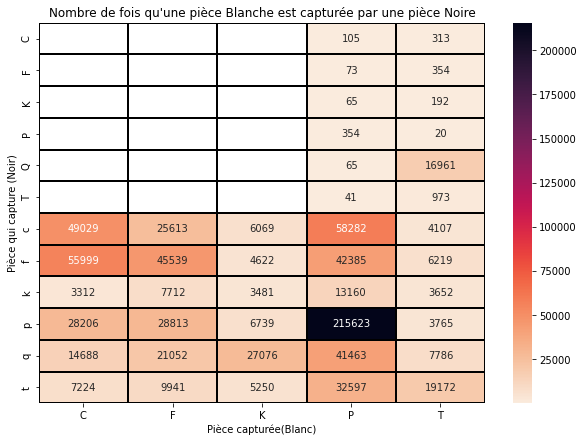

In [45]:
#heatmap du nombre de fois qu'une pièce blanche est capturée par une pièce noire
fig = plt.figure(figsize=(10,7))

df_capturedWhite = df_capturedWhite.groupby(['White captured', 'Black capturing']).size().reset_index(name='count')
heatmapWhitecaptured = sns.heatmap(df_capturedWhite.pivot(index='Black capturing',
                                    columns='White captured',values='count'),
                                   annot=True,cbar=True,cmap='rocket_r', linewidth = .01, 
                                   linecolor = 'black', 
                                   fmt = '.0f')
heatmapWhitecaptured.set_title("Nombre de fois qu'une pièce Blanche est capturée par une pièce Noire")
heatmapWhitecaptured.set_ylabel('Pièce qui capture (Noir)')
heatmapWhitecaptured.set_xlabel('Pièce capturée(Blanc)')

#### Captures des pièces noires

In [48]:
#représentation de capture black sous forme dataframe et groupby
df_Black = pd.DataFrame.from_records(CapturedBlack)
df_capturedBlack = df_Black[[2, 3]]
df_capturedBlack = df_capturedBlack.rename(columns = { 2 : 'Black captured', 3 : 'White capturing'})

Text(0.5, 42.0, 'Pièce capturée (Noir)')

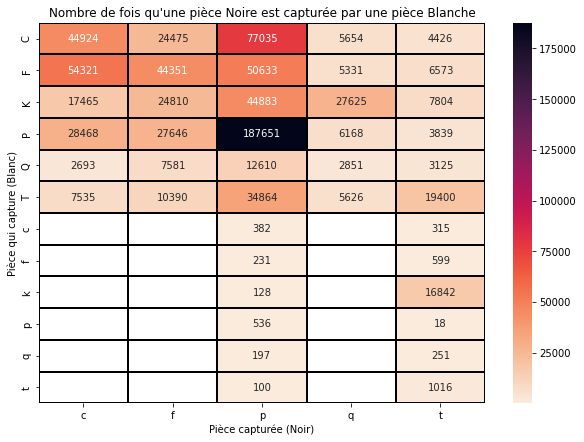

In [49]:
#heatmap du nombre de fois qu'une pièce noire est capturée par une pièce blanche
fig = plt.figure(figsize=(10,7))

df_capturedBlack = df_capturedBlack.groupby(['Black captured', 'White capturing']).size().reset_index(name='count')
heatmapBlackcaptured = sns.heatmap(df_capturedBlack.pivot(index='White capturing',columns='Black captured',values='count'),
                                   annot=True,cbar=True,cmap='rocket_r', linewidth = .01, 
                                   linecolor = 'black', fmt = '.0f')
heatmapBlackcaptured.set_title("Nombre de fois qu'une pièce Noire est capturée par une pièce Blanche")
heatmapBlackcaptured.set_ylabel('Pièce qui capture (Blanc)')
heatmapBlackcaptured.set_xlabel('Pièce capturée (Noir)')

#### Représentation des captures par case de l'échiquier

In [50]:
df_White_Position = df_White[[1]].rename(columns = {1 : 'coord'})
df_Black_Position = df_Black[[1]].rename(columns = {1 :'coord'})
df_White_Position = df_White_Position.groupby(['coord']).size().reset_index(name='count')
df_Black_Position = df_Black_Position.groupby(['coord']).size().reset_index(name='count')

In [51]:
df_Position = pd.merge(df_White_Position, df_Black_Position, how = 'outer', on='coord')
df_Position['count_x'] = df_Position['count_x'].replace(np.NaN, 0)
df_Position['count_y'] = df_Position['count_y'].replace(np.NaN, 0)
count = df_Position['count_x'] + df_Position['count_y']

In [52]:
df_Position = df_Position.assign(count = count)
df_Position = df_Position[['coord', 'count']]
df_Position['coord_lettre'] = df_Position['coord'].str[0]
df_Position['coord_chiffre'] = df_Position['coord'].str[1]
df_Position = df_Position[['count', 'coord_lettre', 'coord_chiffre']]

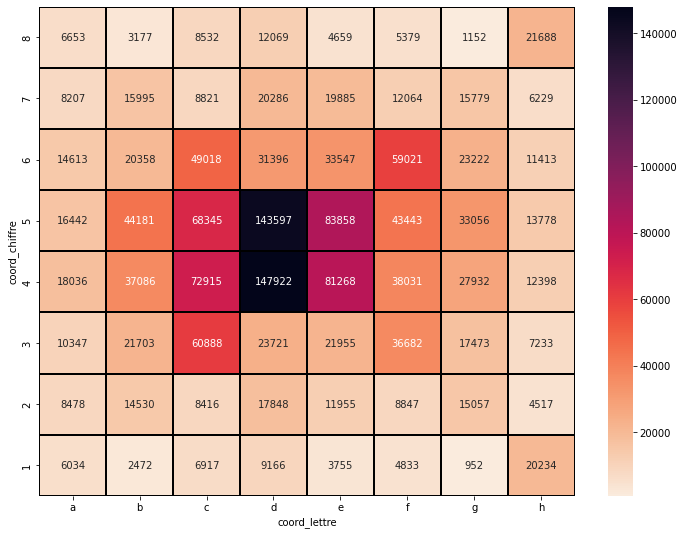

In [57]:
#heatmap des cases sur lesquelles on a le plus de captures de pièce
fig = plt.figure(figsize=(12,9))

heatmapPosition = sns.heatmap(df_Position.pivot(index='coord_chiffre',columns='coord_lettre',values='count'), 
                              annot=True,cbar=True,cmap='rocket_r', linewidth = .01, 
                              linecolor = 'black', fmt='d')
heatmapPosition.invert_yaxis()